# LEARNING

This notebook serves as supporting material for topics covered in **Chapter 18 - Learning from Examples** , **Chapter 19 - Knowledge in Learning**, **Chapter 20 - Learning Probabilistic Models** from the book *Artificial Intelligence: A Modern Approach*. This notebook uses implementations from [learning.py](https://github.com/aimacode/aima-python/blob/master/learning.py). Let's start by importing everything from the module:

In [1]:
from learning import *
from probabilistic_learning import *
from notebook import *

## CONTENTS

* Machine Learning Overview
* Datasets
* Iris Visualization
* Distance Functions
* Plurality Learner
* k-Nearest Neighbours
* Decision Tree Learner
* Random Forest Learner
* Naive Bayes Learner
* Perceptron
* Learner Evaluation

## MACHINE LEARNING OVERVIEW

In this notebook, we learn about agents that can improve their behavior through diligent study of their own experiences.

An agent is **learning** if it improves its performance on future tasks after making observations about the world.

There are three types of feedback that determine the three main types of learning:

* **Supervised Learning**:

In Supervised Learning the agent observes some example input-output pairs and learns a function that maps from input to output.

**Example**: Let's think of an agent to classify images containing cats or dogs. If we provide an image containing a cat or a dog, this agent should output a string "cat" or "dog" for that particular image. To teach this agent, we will give a lot of input-output pairs like {cat image-"cat"}, {dog image-"dog"} to the agent. The agent then learns a function that maps from an input image to one of those strings.

* **Unsupervised Learning**:

In Unsupervised Learning the agent learns patterns in the input even though no explicit feedback is supplied. The most common type is **clustering**: detecting potential useful clusters of input examples.

**Example**: A taxi agent would develop a concept of *good traffic days* and *bad traffic days* without ever being given labeled examples.

* **Reinforcement Learning**:

In Reinforcement Learning the agent learns from a series of reinforcements—rewards or punishments.

**Example**: Let's talk about an agent to play the popular Atari game—[Pong](http://www.ponggame.org). We will reward a point for every correct move and deduct a point for every wrong move from the agent. Eventually, the agent will figure out its actions prior to reinforcement were most responsible for it.

## DATASETS

For the following tutorials we will use a range of datasets, to better showcase the strengths and weaknesses of the algorithms. The datasests are the following:

* [Fisher's Iris](https://github.com/aimacode/aima-data/blob/a21fc108f52ad551344e947b0eb97df82f8d2b2b/iris.csv): Each item represents a flower, with four measurements: the length and the width of the sepals and petals. Each item/flower is categorized into one of three species: Setosa, Versicolor and Virginica.

* [Zoo](https://github.com/aimacode/aima-data/blob/a21fc108f52ad551344e947b0eb97df82f8d2b2b/zoo.csv): The dataset holds different animals and their classification as "mammal", "fish", etc. The new animal we want to classify has the following measurements: 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 4, 1, 0, 1 (don't concern yourself with what the measurements mean).

To make using the datasets easier, we have written a class, `DataSet`, in `learning.py`. The tutorials found here make use of this class.

Let's have a look at how it works before we get started with the algorithms.

### Intro

A lot of the datasets we will work with are .csv files (although other formats are supported too). We have a collection of sample datasets ready to use [on aima-data](https://github.com/aimacode/aima-data/tree/a21fc108f52ad551344e947b0eb97df82f8d2b2b). Two examples are the datasets mentioned above (*iris.csv* and *zoo.csv*). You can find plenty datasets online, and a good repository of such datasets is [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.html).

In such files, each line corresponds to one item/measurement. Each individual value in a line represents a *feature* and usually there is a value denoting the *class* of the item.

You can find the code for the dataset here:

In [ ]:
%psource DataSet

### Class Attributes

* **examples**: Holds the items of the dataset. Each item is a list of values.

* **attrs**: The indexes of the features (by default in the range of [0,f), where *f* is the number of features). For example, `item[i]` returns the feature at index *i* of *item*.

* **attrnames**: An optional list with attribute names. For example, `item[s]`, where *s* is a feature name, returns the feature of name *s* in *item*.

* **target**: The attribute a learning algorithm will try to predict. By default the last attribute.

* **inputs**: This is the list of attributes without the target.

* **values**: A list of lists which holds the set of possible values for the corresponding attribute/feature. If initially `None`, it gets computed (by the function `setproblem`) from the examples.

* **distance**: The distance function used in the learner to calculate the distance between two items. By default `mean_boolean_error`.

* **name**: Name of the dataset.

* **source**: The source of the dataset (url or other). Not used in the code.

* **exclude**: A list of indexes to exclude from `inputs`. The list can include either attribute indexes (attrs) or names (attrnames).

### Class Helper Functions

These functions help modify a `DataSet` object to your needs.

* **sanitize**: Takes as input an example and returns it with non-input (target) attributes replaced by `None`. Useful for testing. Keep in mind that the example given is not itself sanitized, but instead a sanitized copy is returned.

* **classes_to_numbers**: Maps the class names of a dataset to numbers. If the class names are not given, they are computed from the dataset values. Useful for classifiers that return a numerical value instead of a string.

* **remove_examples**: Removes examples containing a given value. Useful for removing examples with missing values, or for removing classes (needed for binary classifiers).

### Importing a Dataset

#### Importing from aima-data

Datasets uploaded on aima-data can be imported with the following line:

In [3]:
iris = DataSet(name="iris")

To check that we imported the correct dataset, we can do the following:

In [4]:
print(iris.examples[0])
print(iris.inputs)

[5.1, 3.5, 1.4, 0.2, 'setosa']
[0, 1, 2, 3]


Which correctly prints the first line in the csv file and the list of attribute indexes.

When importing a dataset, we can specify to exclude an attribute (for example, at index 1) by setting the parameter `exclude` to the attribute index or name.

In [5]:
iris2 = DataSet(name="iris",exclude=[1])
print(iris2.inputs)

[0, 2, 3]


### Attributes

Here we showcase the attributes.

First we will print the first three items/examples in the dataset.

In [6]:
print(iris.examples[:3])

[[5.1, 3.5, 1.4, 0.2, 'setosa'], [4.9, 3.0, 1.4, 0.2, 'setosa'], [4.7, 3.2, 1.3, 0.2, 'setosa']]


Then we will print `attrs`, `attrnames`, `target`, `input`. Notice how `attrs` holds values in [0,4], but since the fourth attribute is the target, `inputs` holds values in [0,3].

In [7]:
print("attrs:", iris.attrs)
print("attrnames (by default same as attrs):", iris.attr_names)
print("target:", iris.target)
print("inputs:", iris.inputs)

attrs: [0, 1, 2, 3, 4]
attrnames (by default same as attrs): [0, 1, 2, 3, 4]
target: 4
inputs: [0, 1, 2, 3]


Now we will print all the possible values for the first feature/attribute.

In [8]:
print(iris.values[0])

[4.7, 5.5, 6.3, 5.0, 4.9, 5.1, 4.6, 5.4, 4.4, 4.8, 5.8, 7.0, 7.1, 4.5, 5.9, 5.6, 6.9, 6.6, 6.5, 6.4, 6.0, 6.1, 7.6, 7.4, 7.9, 4.3, 5.7, 5.3, 5.2, 6.7, 6.2, 6.8, 7.3, 7.2, 7.7]


Finally we will print the dataset's name and source. Keep in mind that we have not set a source for the dataset, so in this case it is empty.

In [9]:
print("name:", iris.name)
print("source:", iris.source)

name: iris
source: 


A useful combination of the above is `dataset.values[dataset.target]` which returns the possible values of the target. For classification problems, this will return all the possible classes. Let's try it:

In [10]:
print(iris.values[iris.target])

['setosa', 'virginica', 'versicolor']


### Helper Functions

We will now take a look at the auxiliary functions found in the class.

First we will take a look at the `sanitize` function, which sets the non-input values of the given example to `None`.

In this case we want to hide the class of the first example, so we will sanitize it.

Note that the function doesn't actually change the given example; it returns a sanitized *copy* of it.

In [11]:
print("Sanitized:",iris.sanitize(iris.examples[0]))
print("Original:",iris.examples[0])

Sanitized: [5.1, 3.5, 1.4, 0.2, None]
Original: [5.1, 3.5, 1.4, 0.2, 'setosa']


Currently the `iris` dataset has three classes, setosa, virginica and versicolor. We want though to convert it to a binary class dataset (a dataset with two classes). The class we want to remove is "virginica". To accomplish that we will utilize the helper function `remove_examples`.

In [12]:
iris2 = DataSet(name="iris")

iris2.remove_examples("virginica")
print(iris2.values[iris2.target])

['setosa', 'versicolor']


We also have `classes_to_numbers`. For a lot of the classifiers in the module (like the Neural Network), classes should have numerical values. With this function we map string class names to numbers.

In [13]:
print("Class of first example:",iris2.examples[0][iris2.target])
iris2.classes_to_numbers()
print("Class of first example:",iris2.examples[0][iris2.target])

Class of first example: setosa
Class of first example: 0


As you can see "setosa" was mapped to 0.

Finally, we take a look at `find_means_and_deviations`. It finds the means and standard deviations of the features for each class.

In [14]:
means, deviations = iris.find_means_and_deviations()

print("Setosa feature means:", means["setosa"])
print("Versicolor mean for first feature:", means["versicolor"][0])

print("Setosa feature deviations:", deviations["setosa"])
print("Virginica deviation for second feature:",deviations["virginica"][1])

Setosa feature means: [5.006, 3.418, 1.464, 0.244]
Versicolor mean for first feature: 5.936
Setosa feature deviations: [0.3524896872134513, 0.38102439795469095, 0.17351115943644546, 0.10720950308167838]
Virginica deviation for second feature: 0.32249663817263746


## IRIS VISUALIZATION

Since we will use the iris dataset extensively in this notebook, below we provide a visualization tool that helps in comprehending the dataset and thus how the algorithms work.

We plot the dataset in a 3D space using `matplotlib` and the function `show_iris` from `notebook.py`. The function takes as input three parameters, *i*, *j* and *k*, which are indicises to the iris features, "Sepal Length", "Sepal Width", "Petal Length" and "Petal Width" (0 to 3). By default we show the first three features.

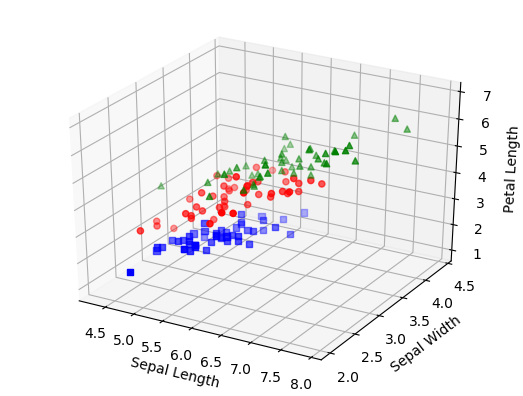

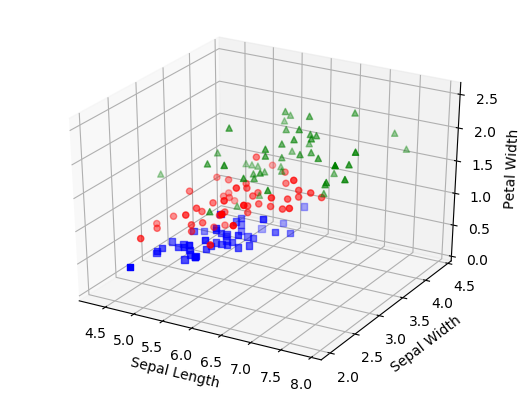

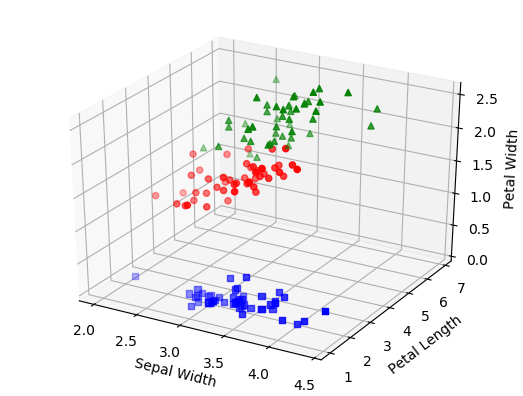

In [15]:
iris = DataSet(name="iris")

show_iris()
show_iris(0, 1, 3)
show_iris(1, 2, 3)

You can play around with the values to get a good look at the dataset.

## DISTANCE FUNCTIONS

In a lot of algorithms (like the *k-Nearest Neighbors* algorithm), there is a need to compare items, finding how *similar* or *close* they are. For that we have many different functions at our disposal. Below are the functions implemented in the module:

### Manhattan Distance (`manhattan_distance`)

One of the simplest distance functions. It calculates the difference between the coordinates/features of two items. To understand how it works, imagine a 2D grid with coordinates *x* and *y*. In that grid we have two items, at the squares positioned at `(1,2)` and `(3,4)`. The difference between their two coordinates is `3-1=2` and `4-2=2`. If we sum these up we get `4`. That means to get from `(1,2)` to `(3,4)` we need four moves; two to the right and two more up. The function works similarly for n-dimensional grids.

In [16]:
def manhattan_distance(X, Y):
    return sum([abs(x - y) for x, y in zip(X, Y)])


distance = manhattan_distance([1,2], [3,4])
print("Manhattan Distance between (1,2) and (3,4) is", distance)

Manhattan Distance between (1,2) and (3,4) is 4


### Euclidean Distance (`euclidean_distance`)

Probably the most popular distance function. It returns the square root of the sum of the squared differences between individual elements of two items.

In [17]:
def euclidean_distance(X, Y):
    return math.sqrt(sum([(x - y)**2 for x, y in zip(X,Y)]))


distance = euclidean_distance([1,2], [3,4])
print("Euclidean Distance between (1,2) and (3,4) is", distance)

Euclidean Distance between (1,2) and (3,4) is 2.8284271247461903


### Hamming Distance (`hamming_distance`)

This function counts the number of differences between single elements in two items. For example, if we have two binary strings "111" and "011" the function will return 1, since the two strings only differ at the first element. The function works the same way for non-binary strings too.

In [18]:
def hamming_distance(X, Y):
    return sum(x != y for x, y in zip(X, Y))


distance = hamming_distance(['a','b','c'], ['a','b','b'])
print("Hamming Distance between 'abc' and 'abb' is", distance)

Hamming Distance between 'abc' and 'abb' is 1


### Mean Boolean Error (`mean_boolean_error`)

To calculate this distance, we find the ratio of different elements over all elements of two items. For example, if the two items are `(1,2,3)` and `(1,4,5)`, the ration of different/all elements is 2/3, since they differ in two out of three elements.

In [19]:
def mean_boolean_error(X, Y):
    return mean(int(x != y) for x, y in zip(X, Y))


distance = mean_boolean_error([1,2,3], [1,4,5])
print("Mean Boolean Error Distance between (1,2,3) and (1,4,5) is", distance)

Mean Boolean Error Distance between (1,2,3) and (1,4,5) is 0.6666666666666666


### Mean Error (`mean_error`)

This function finds the mean difference of single elements between two items. For example, if the two items are `(1,0,5)` and `(3,10,5)`, their error distance is `(3-1) + (10-0) + (5-5) = 2 + 10 + 0 = 12`. The mean error distance therefore is `12/3=4`.

In [20]:
def mean_error(X, Y):
    return mean([abs(x - y) for x, y in zip(X, Y)])


distance = mean_error([1,0,5], [3,10,5])
print("Mean Error Distance between (1,0,5) and (3,10,5) is", distance)

Mean Error Distance between (1,0,5) and (3,10,5) is 4


### Mean Square Error (`ms_error`)

This is very similar to the `Mean Error`, but instead of calculating the difference between elements, we are calculating the *square* of the differences.

In [21]:
def ms_error(X, Y):
    return mean([(x - y)**2 for x, y in zip(X, Y)])


distance = ms_error([1,0,5], [3,10,5])
print("Mean Square Distance between (1,0,5) and (3,10,5) is", distance)

Mean Square Distance between (1,0,5) and (3,10,5) is 34.666666666666664


### Root of Mean Square Error (`rms_error`)

This is the square root of `Mean Square Error`.

In [22]:
def rms_error(X, Y):
    return math.sqrt(ms_error(X, Y))


distance = rms_error([1,0,5], [3,10,5])
print("Root of Mean Error Distance between (1,0,5) and (3,10,5) is", distance)

Root of Mean Error Distance between (1,0,5) and (3,10,5) is 5.887840577551898


## PLURALITY LEARNER CLASSIFIER

### Overview

The Plurality Learner is a simple algorithm, used mainly as a baseline comparison for other algorithms. It finds the most popular class in the dataset and classifies any subsequent item to that class. Essentially, it classifies every new item to the same class. For that reason, it is not used very often, instead opting for more complicated algorithms when we want accurate classification.

![pL plot](images/pluralityLearner_plot.png)

Let's see how the classifier works with the plot above. There are three classes named **Class A** (orange-colored dots) and **Class B** (blue-colored dots) and **Class C** (green-colored dots). Every point in this plot has two **features** (i.e. X<sub>1</sub>, X<sub>2</sub>). Now, let's say we have a new point, a red star and we want to know which class this red star belongs to. Solving this problem by predicting the class of this new red star is our current classification problem.

The Plurality Learner will find the class most represented in the plot. ***Class A*** has four items, ***Class B*** has three and ***Class C*** has seven. The most popular class is ***Class C***. Therefore, the item will get classified in ***Class C***, despite the fact that it is closer to the other two classes.

### Implementation

Below follows the implementation of the PluralityLearner algorithm:

In [ ]:
psource(PluralityLearner)

It takes as input a dataset and returns a function. We can later call this function with the item we want to classify as the argument and it returns the class it should be classified in.

The function first finds the most popular class in the dataset and then each time we call its "predict" function, it returns it. Note that the input ("example") does not matter. The function always returns the same class.

### Example

For this example, we will not use the Iris dataset, since each class is represented the same. This will throw an error. Instead we will use the zoo dataset.

In [24]:
zoo = DataSet(name="zoo")

pL = PluralityLearner(zoo)
print(pL([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 4, 1, 0, 1]))

mammal


The output for the above code is "mammal", since that is the most popular and common class in the dataset.

## K-NEAREST NEIGHBOURS CLASSIFIER

### Overview
The k-Nearest Neighbors algorithm is a non-parametric method used for classification and regression. We are going to use this to classify Iris flowers. More about kNN on [Scholarpedia](http://www.scholarpedia.org/article/K-nearest_neighbor).

![kNN plot](images/knn_plot.png)

Let's see how kNN works with a simple plot shown in the above picture.

We have co-ordinates (we call them **features** in Machine Learning) of this red star and we need to predict its class using the kNN algorithm. In this algorithm, the value of **k** is arbitrary. **k** is one of the **hyper parameters** for kNN algorithm. We choose this number based on our dataset and choosing a particular number is known as **hyper parameter tuning/optimising**. We learn more about this in coming topics.

Let's put **k = 3**. It means you need to find 3-Nearest Neighbors of this red star and classify this new point into the majority class. Observe that smaller circle which contains three points other than **test point** (red star). As there are two violet points, which form the majority, we predict the class of red star as **violet- Class B**.

Similarly if we put **k = 5**, you can observe that there are three yellow points, which form the majority. So, we classify our test point as **yellow- Class A**.

In practical tasks, we iterate through a bunch of values for k (like [1, 3, 5, 10, 20, 50, 100]), see how it performs and select the best one. 

### Implementation

Below follows the implementation of the kNN algorithm:

In [ ]:
psource(NearestNeighborLearner)

It takes as input a dataset and k (default value is 1) and it returns a function, which we can later use to classify a new item.

To accomplish that, the function uses a heap-queue, where the items of the dataset are sorted according to their distance from *example* (the item to classify). We then take the k smallest elements from the heap-queue and we find the majority class. We classify the item to this class.

### Example

We measured a new flower with the following values: 5.1, 3.0, 1.1, 0.1. We want to classify that item/flower in a class. To do that, we write the following:

In [26]:
iris = DataSet(name="iris")

kNN = NearestNeighborLearner(iris,k=3)
print(kNN([5.1,3.0,1.1,0.1]))

setosa


The output of the above code is "setosa", which means the flower with the above measurements is of the "setosa" species.

## DECISION TREE LEARNER

### Overview

#### Decision Trees
A decision tree is a flowchart that uses a tree of decisions and their possible consequences for classification. At each non-leaf node of the tree an attribute of the input is tested, based on which corresponding branch leading to a child-node is selected. At the leaf node the input is classified based on the class label of this leaf node. The paths from root to leaves represent classification rules based on which leaf nodes are assigned class labels.
![perceptron](images/decisiontree_fruit.jpg)
#### Decision Tree Learning
Decision tree learning is the construction of a decision tree from class-labeled training data. The data is expected to be a tuple in which each record of the tuple is an attribute used for classification. The decision tree is built top-down, by choosing a variable at each step that best splits the set of items. There are different metrics for measuring the "best split". These generally measure the homogeneity of the target variable within the subsets.

#### Gini Impurity
Gini impurity of a set is the probability of a randomly chosen element to be incorrectly labeled if it was randomly labeled according to the distribution of labels in the set.

$$I_G(p) = \sum{p_i(1 - p_i)} = 1 - \sum{p_i^2}$$

We select a split which minimizes the Gini impurity in child nodes.

#### Information Gain
Information gain is based on the concept of entropy from information theory. Entropy is defined as:

$$H(p) = -\sum{p_i \log_2{p_i}}$$

Information Gain is difference between entropy of the parent and weighted sum of entropy of children. The feature used for splitting is the one which provides the most information gain.

#### Pseudocode

You can view the pseudocode by running the cell below:

In [ ]:
pseudocode("Decision Tree Learning")

### Implementation
The nodes of the tree constructed by our learning algorithm are stored using either `DecisionFork` or `DecisionLeaf` based on whether they are a parent node or a leaf node respectively.

In [ ]:
psource(DecisionFork)

`DecisionFork` holds the attribute, which is tested at that node, and a dict of branches. The branches store the child nodes, one for each of the attribute's values. Calling an object of this class as a function with input tuple as an argument returns the next node in the classification path based on the result of the attribute test.

In [ ]:
psource(DecisionLeaf)

The leaf node stores the class label in `result`. All input tuples' classification paths end on a `DecisionLeaf` whose `result` attribute decide their class.

In [ ]:
psource(DecisionTreeLearner)

The implementation of `DecisionTreeLearner` provided in [learning.py](https://github.com/aimacode/aima-python/blob/master/learning.py) uses information gain as the metric for selecting which attribute to test for splitting. The function builds the tree top-down in a recursive manner. Based on the input it makes one of the four choices:
<ol>
<li>If the input at the current step has no training data we return the mode of classes of input data received in the parent step (previous level of recursion).</li>
<li>If all values in training data belong to the same class it returns a `DecisionLeaf` whose class label is the class which all the data belongs to.</li>
<li>If the data has no attributes that can be tested we return the class with highest plurality value in the training data.</li>
<li>We choose the attribute which gives the highest amount of entropy gain and return a `DecisionFork` which splits based on this attribute. Each branch recursively calls `decision_tree_learning` to construct the sub-tree.</li>
</ol>

### Example

We will now use the Decision Tree Learner to classify a sample with values: 5.1, 3.0, 1.1, 0.1.

In [2]:
iris = DataSet(name="iris")

DTL = DecisionTreeLearner(iris)
print(DTL([5.1, 3.0, 1.1, 0.1]))

setosa


As expected, the Decision Tree learner classifies the sample as "setosa" as seen in the previous section.

## RANDOM FOREST LEARNER

### Overview

![random_forest.png](images/random_forest.png)   
Image via [src](https://cdn-images-1.medium.com/max/800/0*tG-IWcxL1jg7RkT0.png)

#### Random Forest

As the name of the algorithm and image above suggest, this algorithm creates the forest with a number of trees. The more number of trees makes the forest robust. In the same way in random forest algorithm, the higher the number of trees in the forest, the higher is the accuray result. The main difference between Random Forest and Decision trees is that, finding the root node and splitting the feature nodes will be random.  

Let's see how Rnadom Forest Algorithm work :   
Random Forest Algorithm works in two steps, first is the creation of random forest and then the prediction. Let's first see the creation :  

The first step in creation is to randomly select 'm' features out of total 'n' features. From these 'm' features calculate the node d using the best split point and then split the node into further nodes using best split. Repeat these steps until 'i' number of nodes are reached. Repeat the entire whole process to build the forest.  

Now, let's see how the prediction works
Take the test features and predict the outcome for each randomly created decision tree. Calculate the votes for each prediction and the prediction which gets the highest votes would be the final prediction.


### Implementation

Below mentioned is the implementation of Random Forest Algorithm.

In [ ]:
psource(RandomForest)

This algorithm creates an ensemble of decision trees using bagging and feature bagging. It takes 'm' examples randomly from the total number of examples and then perform feature bagging with probability p to retain an attribute. All the predictors are predicted from the DecisionTreeLearner and then a final prediction is made.


### Example

We will now use the Random Forest to classify a sample with values: 5.1, 3.0, 1.1, 0.1.

In [4]:
iris = DataSet(name="iris")

DTL = RandomForest(iris)
print(DTL([5.1, 3.0, 1.1, 0.1]))

['versicolor', 'setosa', 'setosa', 'setosa', 'setosa']
setosa


As expected, the Random Forest classifies the sample as "setosa".

## NAIVE BAYES LEARNER

### Overview

#### Theory of Probabilities

The Naive Bayes algorithm is a probabilistic classifier, making use of [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem). The theorem states that the conditional probability of **A** given **B** equals the conditional probability of **B** given **A** multiplied by the probability of **A**, divided by the probability of **B**.

$$P(A|B) = \dfrac{P(B|A)*P(A)}{P(B)}$$

From the theory of Probabilities we have the Multiplication Rule, if the events *X* are independent the following is true:

$$P(X_{1} \cap X_{2} \cap ... \cap X_{n}) = P(X_{1})*P(X_{2})*...*P(X_{n})$$

For conditional probabilities this becomes:

$$P(X_{1}, X_{2}, ..., X_{n}|Y) = P(X_{1}|Y)*P(X_{2}|Y)*...*P(X_{n}|Y)$$

#### Classifying an Item

How can we use the above to classify an item though?

We have a dataset with a set of classes (**C**) and we want to classify an item with a set of features (**F**). Essentially what we want to do is predict the class of an item given the features.

For a specific class, **Class**, we will find the conditional probability given the item features:

$$P(Class|F) = \dfrac{P(F|Class)*P(Class)}{P(F)}$$

We will do this for every class and we will pick the maximum. This will be the class the item is classified in.

The features though are a vector with many elements. We need to break the probabilities up using the multiplication rule. Thus the above equation becomes:

$$P(Class|F) = \dfrac{P(Class)*P(F_{1}|Class)*P(F_{2}|Class)*...*P(F_{n}|Class)}{P(F_{1})*P(F_{2})*...*P(F_{n})}$$

The calculation of the conditional probability then depends on the calculation of the following:

*a)* The probability of **Class** in the dataset.

*b)* The conditional probability of each feature occurring in an item classified in **Class**.

*c)* The probabilities of each individual feature.

For *a)*, we will count how many times **Class** occurs in the dataset (aka how many items are classified in a particular class).

For *b)*, if the feature values are discrete ('Blue', '3', 'Tall', etc.), we will count how many times a feature value occurs in items of each class. If the feature values are not discrete, we will go a different route. We will use a distribution function to calculate the probability of values for a given class and feature. If we know the distribution function of the dataset, then great, we will use it to compute the probabilities. If we don't know the function, we can assume the dataset follows the normal (Gaussian) distribution without much loss of accuracy. In fact, it can be proven that any distribution tends to the Gaussian the larger the population gets (see [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)).

*NOTE:* If the values are continuous but use the discrete approach, there might be issues if we are not lucky. For one, if we have two values, '5.0 and 5.1', with the discrete approach they will be two completely different values, despite being so close. Second, if we are trying to classify an item with a feature value of '5.15', if the value does not appear for the feature, its probability will be 0. This might lead to misclassification. Generally, the continuous approach is more accurate and more useful, despite the overhead of calculating the distribution function.

The last one, *c)*, is tricky. If feature values are discrete, we can count how many times they occur in the dataset. But what if the feature values are continuous? Imagine a dataset with a height feature. Is it worth it to count how many times each value occurs? Most of the time it is not, since there can be miscellaneous differences in the values (for example, 1.7 meters and 1.700001 meters are practically equal, but they count as different values).

So as we cannot calculate the feature value probabilities, what are we going to do?

Let's take a step back and rethink exactly what we are doing. We are essentially comparing conditional probabilities of all the classes. For two classes, **A** and **B**, we want to know which one is greater:

$$\dfrac{P(F|A)*P(A)}{P(F)} vs. \dfrac{P(F|B)*P(B)}{P(F)}$$

Wait, **P(F)** is the same for both the classes! In fact, it is the same for every combination of classes. That is because **P(F)** does not depend on a class, thus being independent of the classes.

So, for *c)*, we actually don't need to calculate it at all.

#### Wrapping It Up

Classifying an item to a class then becomes a matter of calculating the conditional probabilities of feature values and the probabilities of classes. This is something very desirable and computationally delicious.

Remember though that all the above are true because we made the assumption that the features are independent. In most real-world cases that is not true though. Is that an issue here? Fret not, for the the algorithm is very efficient even with that assumption. That is why the algorithm is called **Naive** Bayes Classifier. We (naively) assume that the features are independent to make computations easier.

### Implementation

The implementation of the Naive Bayes Classifier is split in two; *Learning* and *Simple*. The *learning* classifier takes as input a dataset and learns the needed distributions from that. It is itself split into two, for discrete and continuous features. The *simple* classifier takes as input not a dataset, but already calculated distributions (a dictionary of `CountingProbDist` objects).

#### Discrete

The implementation for discrete values counts how many times each feature value occurs for each class, and how many times each class occurs. The results are stored in a `CountinProbDist` object.

With the below code you can see the probabilities of the class "Setosa" appearing in the dataset and the probability of the first feature (at index 0) of the same class having a value of 5. Notice that the second probability is relatively small, even though if we observe the dataset we will find that a lot of values are around 5. The issue arises because the features in the Iris dataset are continuous, and we are assuming they are discrete. If the features were discrete (for example, "Tall", "3", etc.) this probably wouldn't have been the case and we would see a much nicer probability distribution.

In [30]:
dataset = iris

target_vals = dataset.values[dataset.target]
target_dist = CountingProbDist(target_vals)
attr_dists = {(gv, attr): CountingProbDist(dataset.values[attr])
              for gv in target_vals
              for attr in dataset.inputs}
for example in dataset.examples:
        targetval = example[dataset.target]
        target_dist.add(targetval)
        for attr in dataset.inputs:
            attr_dists[targetval, attr].add(example[attr])


print(target_dist['setosa'])
print(attr_dists['setosa', 0][5.0])

0.3333333333333333
0.10588235294117647


First we found the different values for the classes (called targets here) and calculated their distribution. Next we initialized a dictionary of `CountingProbDist` objects, one for each class and feature. Finally, we iterated through the examples in the dataset and calculated the needed probabilites.

Having calculated the different probabilities, we will move on to the predicting function. It will receive as input an item and output the most likely class. Using the above formula, it will multiply the probability of the class appearing, with the probability of each feature value appearing in the class. It will return the max result.

In [31]:
def predict(example):
    def class_probability(targetval):
        return (target_dist[targetval] *
                product(attr_dists[targetval, attr][example[attr]]
                        for attr in dataset.inputs))
    return argmax(target_vals, key=class_probability)


print(predict([5, 3, 1, 0.1]))

setosa


You can view the complete code by executing the next line:

In [ ]:
psource(NaiveBayesDiscrete)

#### Continuous

In the implementation we use the Gaussian/Normal distribution function. To make it work, we need to find the means and standard deviations of features for each class. We make use of the `find_means_and_deviations` Dataset function. On top of that, we will also calculate the class probabilities as we did with the Discrete approach.

In [33]:
means, deviations = dataset.find_means_and_deviations()

target_vals = dataset.values[dataset.target]
target_dist = CountingProbDist(target_vals)


print(means["setosa"])
print(deviations["versicolor"])

[5.006, 3.418, 1.464, 0.244]
[0.5161711470638634, 0.3137983233784114, 0.46991097723995795, 0.19775268000454405]


You can see the means of the features for the "Setosa" class and the deviations for "Versicolor".

The prediction function will work similarly to the Discrete algorithm. It will multiply the probability of the class occurring with the conditional probabilities of the feature values for the class.

Since we are using the Gaussian distribution, we will input the value for each feature into the Gaussian function, together with the mean and deviation of the feature. This will return the probability of the particular feature value for the given class. We will repeat for each class and pick the max value.

In [34]:
def predict(example):
    def class_probability(targetval):
        prob = target_dist[targetval]
        for attr in dataset.inputs:
            prob *= gaussian(means[targetval][attr], deviations[targetval][attr], example[attr])
        return prob

    return argmax(target_vals, key=class_probability)


print(predict([5, 3, 1, 0.1]))

setosa


The complete code of the continuous algorithm:

In [ ]:
psource(NaiveBayesContinuous)

#### Simple

The simple classifier (chosen with the argument `simple`) does not learn from a dataset, instead it takes as input a dictionary of already calculated `CountingProbDist` objects and returns a predictor function. The dictionary is in the following form: `(Class Name, Class Probability): CountingProbDist Object`.

Each class has its own probability distribution. The classifier given a list of features calculates the probability of the input for each class and returns the max. The only pre-processing work is to create dictionaries for the distribution of classes (named `targets`) and attributes/features.

The complete code for the simple classifier:

In [ ]:
psource(NaiveBayesSimple)

This classifier is useful when you already have calculated the distributions and you need to predict future items.

### Examples

We will now use the Naive Bayes Classifier (Discrete and Continuous) to classify items:

In [36]:
nBD = NaiveBayesLearner(iris, continuous=False)
print("Discrete Classifier")
print(nBD([5, 3, 1, 0.1]))
print(nBD([6, 5, 3, 1.5]))
print(nBD([7, 3, 6.5, 2]))


nBC = NaiveBayesLearner(iris, continuous=True)
print("\nContinuous Classifier")
print(nBC([5, 3, 1, 0.1]))
print(nBC([6, 5, 3, 1.5]))
print(nBC([7, 3, 6.5, 2]))

Discrete Classifier
setosa
setosa
setosa

Continuous Classifier
setosa
versicolor
virginica


Notice how the Discrete Classifier misclassified the second item, while the Continuous one had no problem.

Let's now take a look at the simple classifier. First we will come up with a sample problem to solve. Say we are given three bags. Each bag contains three letters ('a', 'b' and 'c') of different quantities. We are given a string of letters and we are tasked with finding from which bag the string of letters came.

Since we know the probability distribution of the letters for each bag, we can use the naive bayes classifier to make our prediction.

In [2]:
bag1 = 'a'*50 + 'b'*30 + 'c'*15
dist1 = CountingProbDist(bag1)
bag2 = 'a'*30 + 'b'*45 + 'c'*20
dist2 = CountingProbDist(bag2)
bag3 = 'a'*20 + 'b'*20 + 'c'*35
dist3 = CountingProbDist(bag3)

Now that we have the `CountingProbDist` objects for each bag/class, we will create the dictionary. We assume that it is equally probable that we will pick from any bag.

In [3]:
dist = {('First', 0.5): dist1, ('Second', 0.3): dist2, ('Third', 0.2): dist3}
nBS = NaiveBayesLearner(dist, simple=True)

Now we can start making predictions:

In [4]:
print(nBS('aab'))        # We can handle strings
print(nBS(['b', 'b']))   # And lists!
print(nBS('ccbcc'))

First
Second
Third


The results make intuitive sence. The first bag has a high amount of 'a's, the second has a high amount of 'b's and the third has a high amount of 'c's. The classifier seems to confirm this intuition.

Note that the simple classifier doesn't distinguish between discrete and continuous values. It just takes whatever it is given. Also, the `simple` option on the `NaiveBayesLearner` overrides the `continuous` argument. `NaiveBayesLearner(d, simple=True, continuous=False)` just creates a simple classifier.

## PERCEPTRON CLASSIFIER

### Overview

The Perceptron is a linear classifier. It works the same way as a neural network with no hidden layers (just input and output). First it trains its weights given a dataset and then it can classify a new item by running it through the network.

Its input layer consists of the the item features, while the output layer consists of nodes (also called neurons). Each node in the output layer has *n* synapses (for every item feature), each with its own weight. Then, the nodes find the dot product of the item features and the synapse weights. These values then pass through an activation function (usually a sigmoid). Finally, we pick the largest of the values and we return its index.

Note that in classification problems each node represents a class. The final classification is the class/node with the max output value.

Below you can see a single node/neuron in the outer layer. With *f* we denote the item features, with *w* the synapse weights, then inside the node we have the dot product and the activation function, *g*.

![perceptron](images/perceptron.png)

### Implementation

First, we train (calculate) the weights given a dataset, using the `BackPropagationLearner` function of `learning.py`. We then return a function, `predict`, which we will use in the future to classify a new item. The function computes the (algebraic) dot product of the item with the calculated weights for each node in the outer layer. Then it picks the greatest value and classifies the item in the corresponding class.

In [ ]:
psource(PerceptronLearner)

Note that the Perceptron is a one-layer neural network, without any hidden layers. So, in `BackPropagationLearner`, we will pass no hidden layers. From that function we get our network, which is just one layer, with the weights calculated.

That function `predict` passes the input/example through the network, calculating the dot product of the input and the weights for each node and returns the class with the max dot product.

### Example

We will train the Perceptron on the iris dataset. Because though the `BackPropagationLearner` works with integer indexes and not strings, we need to convert class names to integers. Then, we will try and classify the item/flower with measurements of 5, 3, 1, 0.1.

In [38]:
iris = DataSet(name="iris")
iris.classes_to_numbers()

perceptron = PerceptronLearner(iris)
print(perceptron([5, 3, 1, 0.1]))

0


The correct output is 0, which means the item belongs in the first class, "setosa". Note that the Perceptron algorithm is not perfect and may produce false classifications.

## LINEAR LEARNER

### Overview

Linear Learner is a model that assumes a linear relationship between the input variables x and the single output variable y. More specifically, that y can be calculated from a linear combination of the input variables x. Linear learner is a quite simple model as the representation of this model is a linear equation.  

The linear equation assigns one scaler factor to each input value or column, called a coefficients or weights. One additional coefficient is also added, giving additional degree of freedom and is often called the intercept or the bias coefficient.   
For example :  y = ax1 + bx2 + c .  

### Implementation

Below mentioned is the implementation of Linear Learner.

In [ ]:
psource(LinearLearner)

This algorithm first assigns some random weights to the input variables and then based on the error calculated updates the weight for each variable. Finally the prediction is made with the updated weights.  

### Implementation

We will now use the Linear Learner to classify a sample with values: 5.1, 3.0, 1.1, 0.1.

In [21]:
iris = DataSet(name="iris")
iris.classes_to_numbers()

linear_learner = LinearLearner(iris)
print(linear_learner([5, 3, 1, 0.1]))

0.2404650656510341


## ENSEMBLE LEARNER

### Overview

Ensemble Learning improves the performance of our model by combining several learners. It improvise the stability and predictive power of the model. Ensemble methods are meta-algorithms that combine several machine learning techniques into one predictive model in order to decrease variance, bias, or improve predictions.  



![ensemble_learner.jpg](images/ensemble_learner.jpg)


Some commonly used Ensemble Learning techniques are : 

1. Bagging : Bagging tries to implement similar learners on small sample populations and then takes a mean of all the predictions. It helps us to reduce variance error.

2. Boosting : Boosting is an iterative technique which adjust the weight of an observation based on the last classification. If an observation was classified incorrectly, it tries to increase the weight of this observation and vice versa. It helps us to reduce bias error.

3.  Stacking : This is a very interesting way of combining models. Here we use a learner to combine output from different learners. It can either decrease bias or variance error depending on the learners we use.

### Implementation

Below mentioned is the implementation of Ensemble Learner.

In [ ]:
psource(EnsembleLearner)

This algorithm takes input as a list of learning algorithms, have them vote and then finally returns the predicted result.

## LEARNER EVALUATION

In this section we will evaluate and compare algorithm performance. The dataset we will use will again be the iris one.

In [42]:
iris = DataSet(name="iris")

### Naive Bayes

First up we have the Naive Bayes algorithm. First we will test how well the Discrete Naive Bayes works, and then how the Continuous fares.

In [43]:
nBD = NaiveBayesLearner(iris, continuous=False)
print("Error ratio for Discrete:", err_ratio(nBD, iris))

nBC = NaiveBayesLearner(iris, continuous=True)
print("Error ratio for Continuous:", err_ratio(nBC, iris))

Error ratio for Discrete: 0.040000000000000036
Error ratio for Continuous: 0.040000000000000036


The error for the Naive Bayes algorithm is very, very low; close to 0. There is also very little difference between the discrete and continuous version of the algorithm.

## k-Nearest Neighbors

Now we will take a look at kNN, for different values of *k*. Note that *k* should have odd values, to break any ties between two classes.

In [44]:
kNN_1 = NearestNeighborLearner(iris, k=1)
kNN_3 = NearestNeighborLearner(iris, k=3)
kNN_5 = NearestNeighborLearner(iris, k=5)
kNN_7 = NearestNeighborLearner(iris, k=7)

print("Error ratio for k=1:", err_ratio(kNN_1, iris))
print("Error ratio for k=3:", err_ratio(kNN_3, iris))
print("Error ratio for k=5:", err_ratio(kNN_5, iris))
print("Error ratio for k=7:", err_ratio(kNN_7, iris))

Error ratio for k=1: 0.0
Error ratio for k=3: 0.06000000000000005
Error ratio for k=5: 0.1266666666666667
Error ratio for k=7: 0.19999999999999996


Notice how the error became larger and larger as *k* increased. This is generally the case with datasets where classes are spaced out, as is the case with the iris dataset. If items from different classes were closer together, classification would be more difficult. Usually a value of 1, 3 or 5 for *k* suffices.

Also note that since the training set is also the testing set, for *k* equal to 1 we get a perfect score, since the item we want to classify each time is already in the dataset and its closest neighbor is itself.

### Perceptron

For the Perceptron, we first need to convert class names to integers. Let's see how it performs in the dataset.

In [45]:
iris2 = DataSet(name="iris")
iris2.classes_to_numbers()

perceptron = PerceptronLearner(iris2)
print("Error ratio for Perceptron:", err_ratio(perceptron, iris2))

Error ratio for Perceptron: 0.31333333333333335


The Perceptron didn't fare very well mainly because the dataset is not linearly separated. On simpler datasets the algorithm performs much better, but unfortunately such datasets are rare in real life scenarios.

## AdaBoost

### Overview

**AdaBoost** is an algorithm which uses **ensemble learning**. In ensemble learning the hypotheses in the collection, or ensemble, vote for what the output should be and the output with the majority votes is selected as the final answer.

AdaBoost algorithm, as mentioned in the book, works with a **weighted training set** and **weak learners** (classifiers that have about 50%+epsilon accuracy i.e slightly better than random guessing). It manipulates the weights attached to the the examples that are showed to it. Importance is given to the examples with higher weights.

All the examples start with equal weights and a hypothesis is generated using these examples. Examples which are incorrectly classified, their weights are increased so that they can be classified correctly by the next hypothesis. The examples that are correctly classified, their weights are reduced. This process is repeated *K* times (here *K* is an input to the algorithm) and hence, *K* hypotheses are generated.

These *K* hypotheses are also assigned weights according to their performance on the weighted training set. The final ensemble hypothesis is the weighted-majority combination of these *K* hypotheses.

The speciality of AdaBoost is that by using weak learners and a sufficiently large *K*, a highly accurate classifier can be learned irrespective of the complexity of the function being learned or the dullness of the hypothesis space.

### Implementation

As seen in the previous section, the `PerceptronLearner` does not perform that well on the iris dataset. We'll use perceptron as the learner for the AdaBoost algorithm and try to increase the accuracy. 

Let's first see what AdaBoost is exactly:

In [3]:
psource(AdaBoost)

AdaBoost takes as inputs: **L** and *K* where **L** is the learner and *K* is the number of hypotheses to be generated. The learner **L** takes in as inputs: a dataset and the weights associated with the examples in the dataset. But the `PerceptronLearner` doesnot handle weights and only takes a dataset as its input.  
To remedy that we will give as input to the PerceptronLearner a modified dataset in which the examples will be repeated according to the weights associated to them. Intuitively, what this will do is force the learner to repeatedly learn the same example again and again until it can classify it correctly.   

To convert `PerceptronLearner` so that it can take weights as input too, we will have to pass it through the **`WeightedLearner`** function.

In [ ]:
psource(WeightedLearner)

The `WeightedLearner` function will then call the `PerceptronLearner`, during each iteration, with the modified dataset which contains the examples according to the weights associated with them.

###  Example

We will pass the `PerceptronLearner` through `WeightedLearner` function. Then we will create an `AdaboostLearner` classifier with number of hypotheses or *K* equal to 5.

In [4]:
WeightedPerceptron = WeightedLearner(PerceptronLearner)
AdaboostLearner = AdaBoost(WeightedPerceptron, 5)

In [5]:
iris2 = DataSet(name="iris")
iris2.classes_to_numbers()

adaboost = AdaboostLearner(iris2)

adaboost([5, 3, 1, 0.1])

0

That is the correct answer. Let's check the error rate of adaboost with perceptron.

In [6]:
print("Error ratio for adaboost: ", err_ratio(adaboost, iris2))

Error ratio for adaboost:  0.046666666666666634


It reduced the error rate considerably. Unlike the `PerceptronLearner`, `AdaBoost` was able to learn the complexity in the iris dataset.